In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git
    import os
    os.kill(os.getpid(), 9)

     |████████████████████████████████| 194kB 13.4MB/s 
     |████████████████████████████████| 163kB 22.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 245kB 27.4MB/s 
     |████████████████████████████████| 17.7MB 343kB/s 


In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#all_slow

# enwik8 - baseline

In [3]:
from fastai.text.all import *

from reformer_fastai.tokenizers import ByteTextTokenizer
from reformer_fastai.transformer import TransformerLM
from reformer_fastai.data import read_and_prepare_data, read_lines
from reformer_fastai.metrics import BPC
from reformer_fastai.optimizers import adafactor

## Experiment Tracking

Make sure you have wandb and are logged in:

In [4]:
#hide
!wandb login 

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


Load Experiment Tracking with Weights & Biases:

In [5]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8_base_af'
GROUP = 'TEST'
NOTES = 'Baseline Transformer LM on enwik8 sl 1024'
CONFIG = {}
TAGS =['lm','test','enwik8']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [6]:
# wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
#            name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [7]:
input_file=untar_data('http://mattmahoney.net/dc/enwik8.zip')

## Prepare Data

In [8]:
df = pd.DataFrame({'text':read_lines(input_file)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [9]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [10]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min, sys: 3.19 s, total: 2min 3s
Wall time: 1min 59s


In [11]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [12]:
#hide
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [13]:
%%time
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

CPU times: user 1.16 s, sys: 47.3 ms, total: 1.2 s
Wall time: 1.21 s


In [14]:
%%time
bs, sl = 8, 1024
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 25.8 s, sys: 944 ms, total: 26.7 s
Wall time: 26.7 s


In [15]:
#collapse_output
dls.show_batch(max_n=4)

,text,text_
0,"<id>8613</id>\nWithin the accepted Protestant canon, it is only in the book of Daniel that a &quot;modern&quot; understanding of an afterlife appears. From a Christian point of view, this aforementioned proposed denial of the possibility of afterlife may be interpreted in a different manner: One might see it as a distinction between the &quot;dead&quot; and the &quot;resurrected dead&quot; rather than a denial of the afterlife. The &quot;dead&quot; would represent those who have died outside of God's grace, who by choice do or did not follow God, and thus are dead (spiritually and bodily). The ones who go to be with God, by their choice of faith or actions depending on the religion, would be the &quot;resurrected dead,&quot; &quot;living dead&quot; or, simply, &quot;living.&quot;\n* In [[mathematics]], [[blackboard bold]] &lt;math&gt;\mathbb{H}&lt;/math&gt; represents the [[quaternions]] (after [[William Rowan Hamilton]], &lt;math&gt;\mathbb{Q}&lt;/math&gt; representing the [[rational number|rational]]s).\n|","<id>8613</id>\nWithin the accepted Protestant canon, it is only in the book of Daniel that a &quot;modern&quot; understanding of an afterlife appears. From a Christian point of view, this aforementioned proposed denial of the possibility of afterlife may be interpreted in a different manner: One might see it as a distinction between the &quot;dead&quot; and the &quot;resurrected dead&quot; rather than a denial of the afterlife. The &quot;dead&quot; would represent those who have died outside of God's grace, who by choice do or did not follow God, and thus are dead (spiritually and bodily). The ones who go to be with God, by their choice of faith or actions depending on the religion, would be the &quot;resurrected dead,&quot; &quot;living dead&quot; or, simply, &quot;living.&quot;\n* In [[mathematics]], [[blackboard bold]] &lt;math&gt;\mathbb{H}&lt;/math&gt; represents the [[quaternions]] (after [[William Rowan Hamilton]], &lt;math&gt;\mathbb{Q}&lt;/math&gt; representing the [[rational number|rational]]s).\n|["
1,"varre]] and the [[Basque Country (autonomous community)|Basque Country]], Catalonia lacks its own tax system; thus the economic financing of the regional administration depends almost entirely on funds raised by national-government taxation and budgeted to Catalonia. This has become a mainstream issue, particularly as the proposed reform of the [[Catalan Statute of Autonomy]] is currently the subject of intense political debate at regional and national level. From an economic perspective, the regional government aims to achieve a high degree of fiscal autonomy (based on the argument that the region pays in more to the national Spanish coffers than it receives).\n[[Image:Horloge-republicaine2.jpg|thumb|Clock dial]]\n\n\n==System==\n[http://www.obesity.com.au/bmi.html Body mass index calculations] are not just for adults&amp;mdash;they can also be used to identify the growing number of overweight children. BMI for children aged 2 to 20 years is calculated just as it is for adults, but it is classified differently.","arre]] and the [[Basque Country (autonomous community)|Basque Country]], Catalonia lacks its own tax system; thus the economic financing of the regional administration depends almost entirely on funds raised by national-government taxation and budgeted to Catalonia. This has become a mainstream issue, particularly as the proposed reform of the [[Catalan Statute of Autonomy]] is currently the subject of intense political debate at regional and national level. From an economic perspective, the regional government aims to achieve a high degree of fiscal autonomy (based on the argument that the region pays in more to the national Spanish coffers than it receives).\n[[Image:Horloge-republicaine2.jpg|thumb|Clock dial]]\n\n\n==System==\n[http://www.obesity.com.au/bmi.html Body mass index calculations] are not just for adults&amp;mdash;they can also be used to identify the growing number of over

In [16]:
vocab_sz = btt.vocab_size

In [17]:
#hide
df.drop(columns='toks', inplace=True, )
df.to_csv('enwik8.csv')

In [18]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((8, 1024), (8, 1024))

In [19]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [20]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [21]:
# opt_func = partial(adafactor, warmup_init=True)
#opt_func = adafactor

learn = Learner(dls, TransformerLM(vocab_sz, 1024, n_layers=3, max_seq_len=sl),
                loss_func=CrossEntropyLossFlat(), #opt_func=opt_func,
                metrics=[accuracy, perplexity, BPC()]).to_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

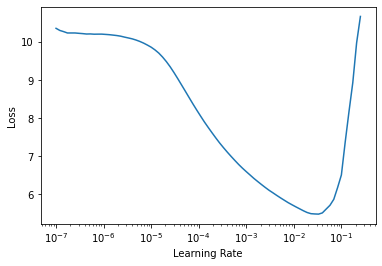

In [22]:
#hide
# Lr find not needed with Adafactor
learn.lr_find()

In [23]:
learn.fit_one_cycle(3, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.486207,1.398917,0.587419,4.050810,2.018210,1:21:20


Buffered data was truncated after reaching the output size limit.

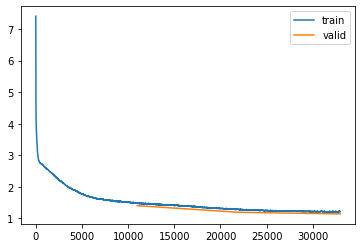

In [24]:
learn.recorder.plot_loss()